In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
from scipy.constants import R

RT = 300 * R * 1e-3

In [3]:
df = plumed.read_as_pandas('data/duplex.COLVAR')

weights = np.exp(df['bias.bias'] / RT)

# Rescaling factor for "nicer" integral values of the coordination numbers
scale = 1.039661

/tmp/ipykernel_13759/2533592485.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  df = plumed.read_as_pandas('../run_duplex/duplex.COLVAR')


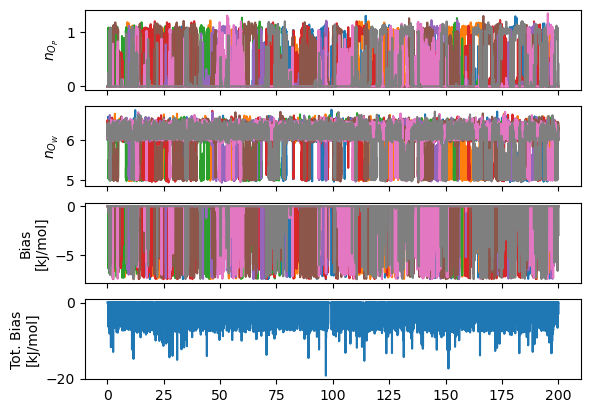

In [4]:
fig, axarr = plt.subplots(nrows=4, sharex=True)

ax = axarr[0]
for i in range(1, 9):
    ax.plot(df.time / 1000, df[f'nop{i}'] * scale)
ax.set_ylabel(r"$n_{O_P}$")

ax = axarr[1]
for i in range(1, 9):
    ax.plot(df.time / 1000, df[f'now{i}'] * scale)
ax.set_ylabel(r"$n_{O_W}$")


ax = axarr[2]
for i in range(1, 9):
    ax.plot(df.time / 1000, df[f'fn{i}'])
ax.set_ylabel("Bias\n[kJ/mol]")

ax = axarr[3]
ax.plot(df.time / 1000, df['bias.bias'])
ax.set_ylabel("Tot. Bias\n[kJ/mol]")

plt.savefig('figures/duplex_timeseries.png')

In [5]:
def kish_ratio(weights):
    return weights.sum()**2 / (weights**2).sum() / len(weights)

print(kish_ratio(weights))

0.8739502599567615


In [6]:
import MDAnalysis as mda

u = mda.Universe("../run_duplex/run.gro", "../run_duplex/run.xtc")

In [7]:
op = u.select_atoms("name O1P O2P")
mg = u.select_atoms("name MG")

In [45]:
from MDAnalysis.analysis.distances import distance_array

dist = np.empty((len(op), len(mg)))
contacts = []
time = []
for ts in u.trajectory:
    dist = distance_array(op, mg, box=ts.dimensions, result=dist)
    contacts.append(dist < 2.3)
    time.append(ts.time)
contacts = np.array(contacts)

<BarContainer object of 12 artists>

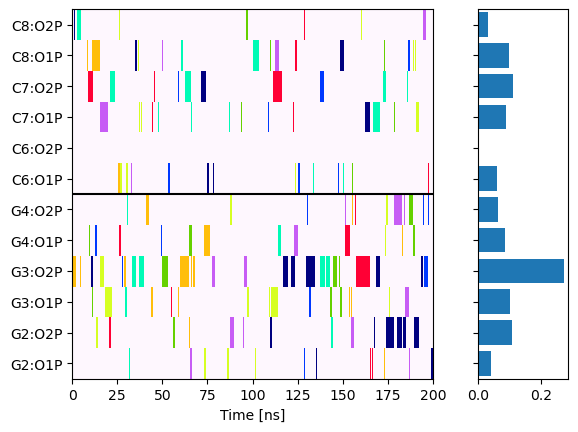

In [64]:
fig, axarr = plt.subplots(ncols=2, width_ratios=[8, 2], sharey=True)

ax = axarr[0]
identities = (contacts * np.arange(1, len(mg) + 1)).sum(axis=-1)
im = ax.imshow(identities.T, 
          aspect='auto', 
          interpolation='none', 
          cmap='gist_ncar_r',
          origin='lower',
          extent=[u.trajectory[0].time / 1000, u.trajectory[-1].time / 1000, -0.5, len(op)-0.5],
)
ax.set_yticks(range(len(op)), labels=[f"{atom.resname}{atom.resid}:{atom.name}" for atom in op])
ax.axhline((len(op) - 1) / 2, color='black')
ax.set_xlabel("Time [ns]")

ax = axarr[1]
ax.barh(range(len(op)), contacts.sum(axis=-1).mean(axis=0))


In [ ]:
# n = 